### The purpose of this project is to create a deep authoencoder with tensorflow to create a model that could randomly generate new characters.


### Dataset: https://www.kaggle.com/soumikrakshit/anime-faces


In [1]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

import numpy as np
import matplotlib.pyplot as plt

import os

from tensorflow.keras.models import Model
from tensorflow.keras import layers

import PIL
from PIL import Image
import glob

import os.path
from os import path

#### Let's load images from dataset.

In [3]:
images = []
for filename in glob.glob('AnimeFaces\*.png'):
    im = Image.open(filename)
    images.append(np.array(im))
    im.close()

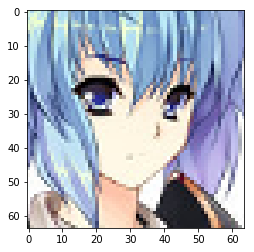

In [4]:
plt.imshow(images[1])

#### How many images do we have?

In [5]:
print(len(images))

19124


#### Let's build Neural Network.
#### 

In [6]:
latent_dim = 100 

class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        
        self.latent_dim = latent_dim  
        
        self.encoder = tf.keras.Sequential([
          layers.Conv2D(filters = 12, 
                        kernel_size = (8,8),
                        activation = lambda x: tf.nn.leaky_relu(x, alpha=0.2)),
          layers.BatchNormalization(),
            
          layers.Flatten(),
          layers.Dense(latent_dim, activation = lambda x: tf.nn.leaky_relu(x, alpha=0.2))
        ])
        
        self.decoder = tf.keras.Sequential([
        layers.Reshape((10,10,1)),
         layers.Conv2DTranspose(filters = 12, 
                        kernel_size = (8,8),
                        activation = lambda x: tf.nn.leaky_relu(x, alpha=0.2)),
          layers.Flatten(),
          layers.BatchNormalization(), 
          layers.Dense(12288, activation='sigmoid'),
          layers.Reshape((64,64,3))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
autoencoder = Autoencoder(latent_dim)
autoencoder.compile(optimizer='adam', loss='MSE') 

In [7]:
if(path.isfile('autoencoder.index')):
    autoencoder.load_weights('autoencoder')

In [8]:
train_data = np.array(images).reshape(-1, 64,64,3)
print(train_data.shape)

train_data = train_data / 255

(19124, 64, 64, 3)


In [11]:
autoencoder.fit(train_data, train_data, epochs = 1)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
19124/19124 [==============================] - 829s 43ms/sample - loss: 0.0224


In [67]:
autoencoder.save_weights('autoencoder')


Consider using a TensorFlow optimizer from `tf.train`.


#### Let's see what out network generates for train dataset

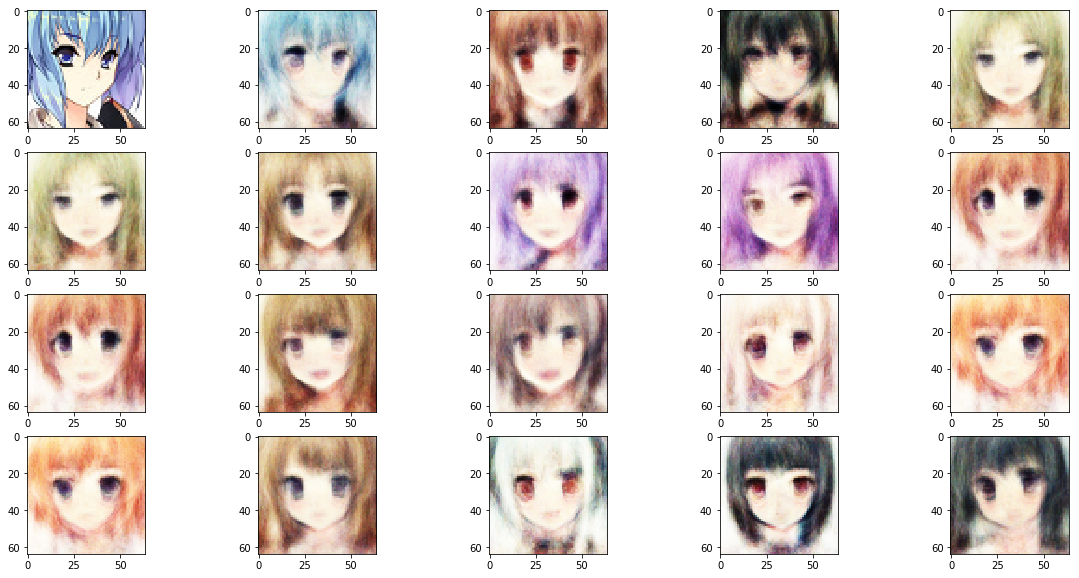

In [12]:
ind = 1
y = autoencoder.predict(train_data[0:30])

i_size = 4
j_size = 5

fig, axs = plt.subplots(i_size, j_size, figsize=(20, 10))

for i in range(i_size):
    for j in range(j_size):
        axs[i, j].imshow(y[i*i_size + j].reshape(64,64,3))

axs[0,0].imshow(train_data[ind].reshape(64,64,3))

plt.show()

#### Let's see what our neural network generates randomly. 
#### Since the last layer of encoder has leaky relu as activation function, our decoder can recieve any number (-Infinity:+Infinity). So let's try doing naive approach and just hope that we will get well generated image by feeding random numbers into our decoder  

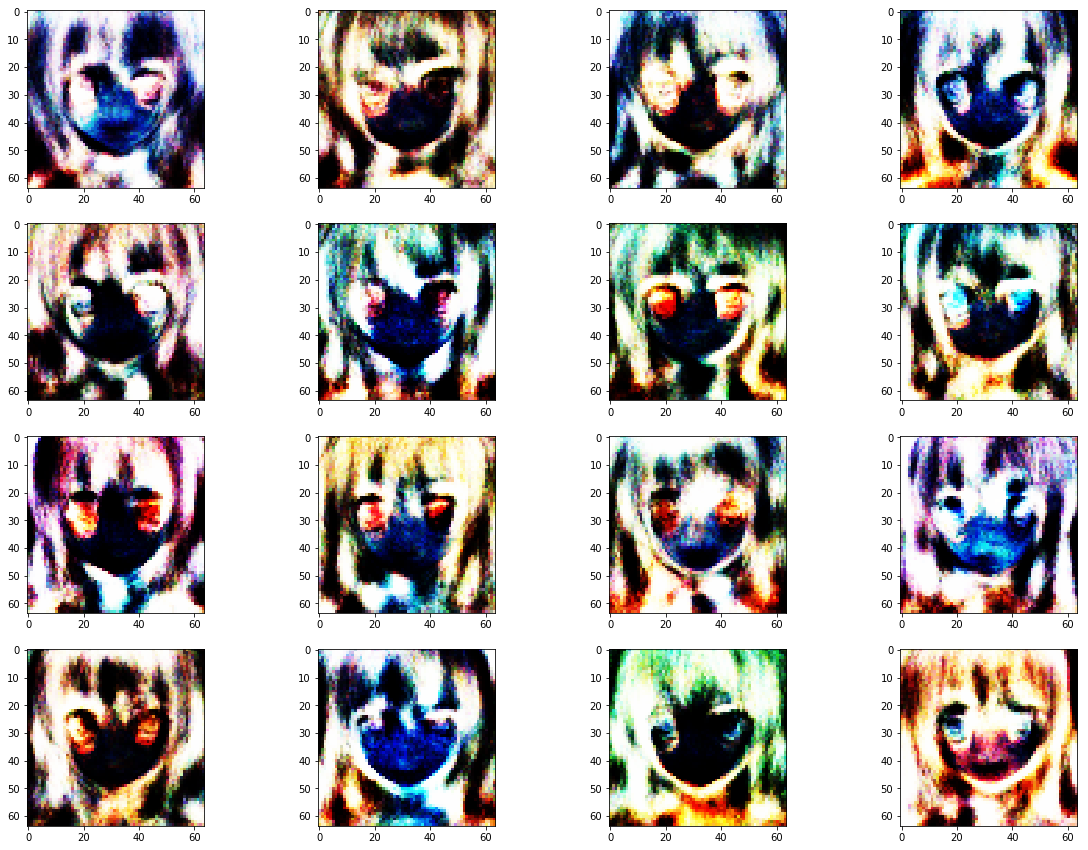

In [13]:
i_size = 4
j_size = 4

fig, axs = plt.subplots(i_size, j_size, figsize=(20, 15))

for i in range(i_size):
    for j in range(j_size):
        rnd = (np.random.rand(1,100).astype('float32') - .5) * 50
        y = autoencoder.decoder(rnd).numpy()
        axs[i, j].imshow(y.reshape(64,64,3))
plt.show()

#### Well, that looks horrible.
#### New idea. What if we generate random numbers based on normal distribution of our encoded values of our dataset. 
#### In other words, what if we run each image through encoder, get encoded representation of each image (a 100 - element long array), find the mean value of each feature in encoded representation (mean value of each element in array), find the standart deviation of each feature and then randomly generate new values from the normal distribution that each feature has

In [14]:
encoded_vals = []

for i in range(len(train_data)):
    encoded_val  = autoencoder.encoder(train_data[i].reshape(-1,64,64,3).astype('float32')).numpy()
    encoded_vals.append(encoded_val)
    
encoded_vals = np.array(encoded_vals)

In [15]:
print(encoded_vals.shape)

(19124, 1, 100)


In [16]:
print(encoded_vals.min())
print(encoded_vals.max())

-88.228714
141.86981


#### Let's see what's the mean and standart deviation for each feature in our encoded values

In [43]:
mean_std = np.zeros((latent_dim, 2))

for i in range(latent_dim):
    mean_std[i, 0] = encoded_vals[:,0,i].mean()
    mean_std[i, 1] = encoded_vals[:,0,i].std()

    print(f'{i}. \t Mean {mean_std[i, 0]} \t Std {mean_std[i, 1]} ')

0. 	 Mean -7.09283971786499 	 Std 2.4192376136779785 
1. 	 Mean -13.442458152770996 	 Std 2.7964682579040527 
2. 	 Mean -11.68018627166748 	 Std 3.3878602981567383 
3. 	 Mean -10.793614387512207 	 Std 3.5499701499938965 
4. 	 Mean -11.378817558288574 	 Std 3.6982040405273438 
5. 	 Mean -12.729084014892578 	 Std 3.1843338012695312 
6. 	 Mean -10.793461799621582 	 Std 3.3819613456726074 
7. 	 Mean -10.199792861938477 	 Std 3.1047744750976562 
8. 	 Mean -9.237691879272461 	 Std 2.6287436485290527 
9. 	 Mean -7.994525909423828 	 Std 2.0810751914978027 
10. 	 Mean -9.263532638549805 	 Std 2.9697554111480713 
11. 	 Mean -16.237539291381836 	 Std 5.978450775146484 
12. 	 Mean 26.979875564575195 	 Std 13.98979377746582 
13. 	 Mean -17.555957794189453 	 Std 5.367252826690674 
14. 	 Mean -22.785249710083008 	 Std 5.249467372894287 
15. 	 Mean -15.266257286071777 	 Std 4.6955389976501465 
16. 	 Mean -12.896370887756348 	 Std 4.347510814666748 
17. 	 Mean -11.37686824798584 	 Std 3.686874151229858

#### Here you can see that each feature has it's own mean and standart deviation, to generate an adequate image values should lie between +-3 standart deviations from the mean, otherwise the image will be an anomaly and we will get some horrible abominations as we have seen before.

#### By the way if we put just the mean values into the decoder we will get what our neural network thinks a true face looks like. Let's see that.

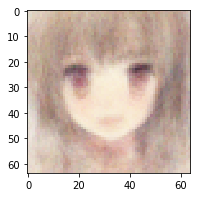

In [58]:
plt.figure(figsize=(3,3))
enc_values = np.zeros((1, 100)) 
for k in range(latent_dim):
        enc_values[0, k] = mean_std[k, 0]
enc_values = enc_values.astype('float32')    
y = autoencoder.decoder(enc_values).numpy()
plt.imshow(y.reshape(64,64,3), cmap='gray', interpolation='none')
plt.show()

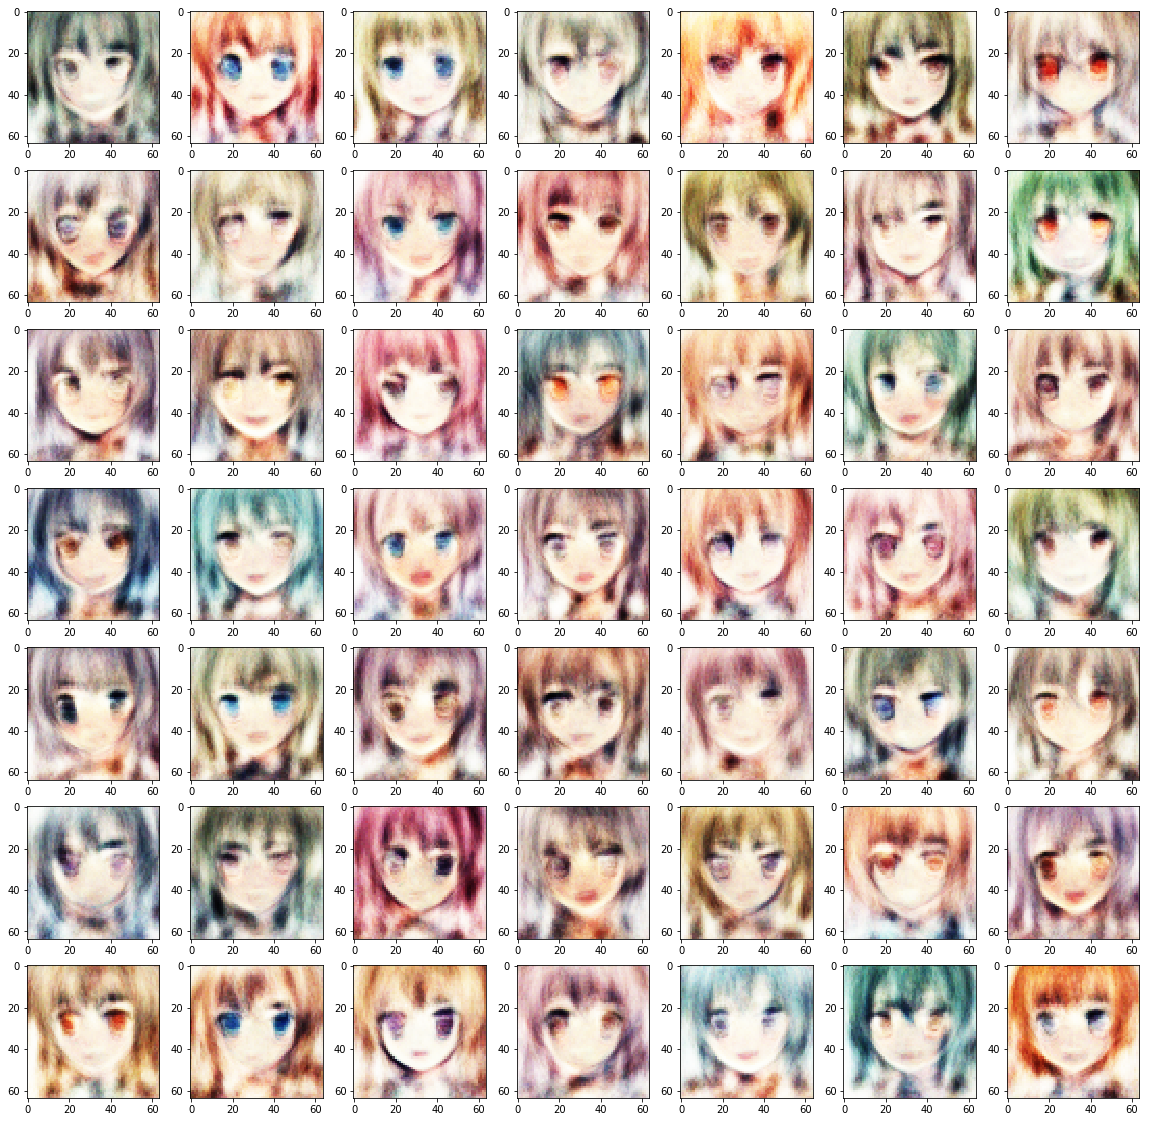

In [62]:
i_size = 7
j_size = 7

fig, axs = plt.subplots(i_size, j_size, figsize=(20, 20))

rnd = np.zeros((1, 100)) 
for i in range(i_size):
    for j in range(j_size):
        for k in range(latent_dim):
            # Generate a random number from normal distribution
            rnd[0, k] = np.random.normal(loc = mean_std[k, 0], 
                                         scale = mean_std[k, 1])
        rnd = rnd.astype('float32')
        y = autoencoder.decoder(rnd).numpy()
        axs[i, j].imshow(y.reshape(64,64,3), cmap='gray', interpolation='none')
plt.show()

#### That looks much better. 
#### Probably we shoud have used a bit more complicated model and train for a bit longer (which I am not going to do because training took 1 hour and the file for trained model is 200MB, this things scale extremly fast) but I think this is quite a good result.

#### Anyway, we can do better.
#### After doing a bit of testing I've discovered that model can't generate good images if encoded values are beyond 1 standart deviation, so here I generate values between +- 1 SD  with uniform distribution.

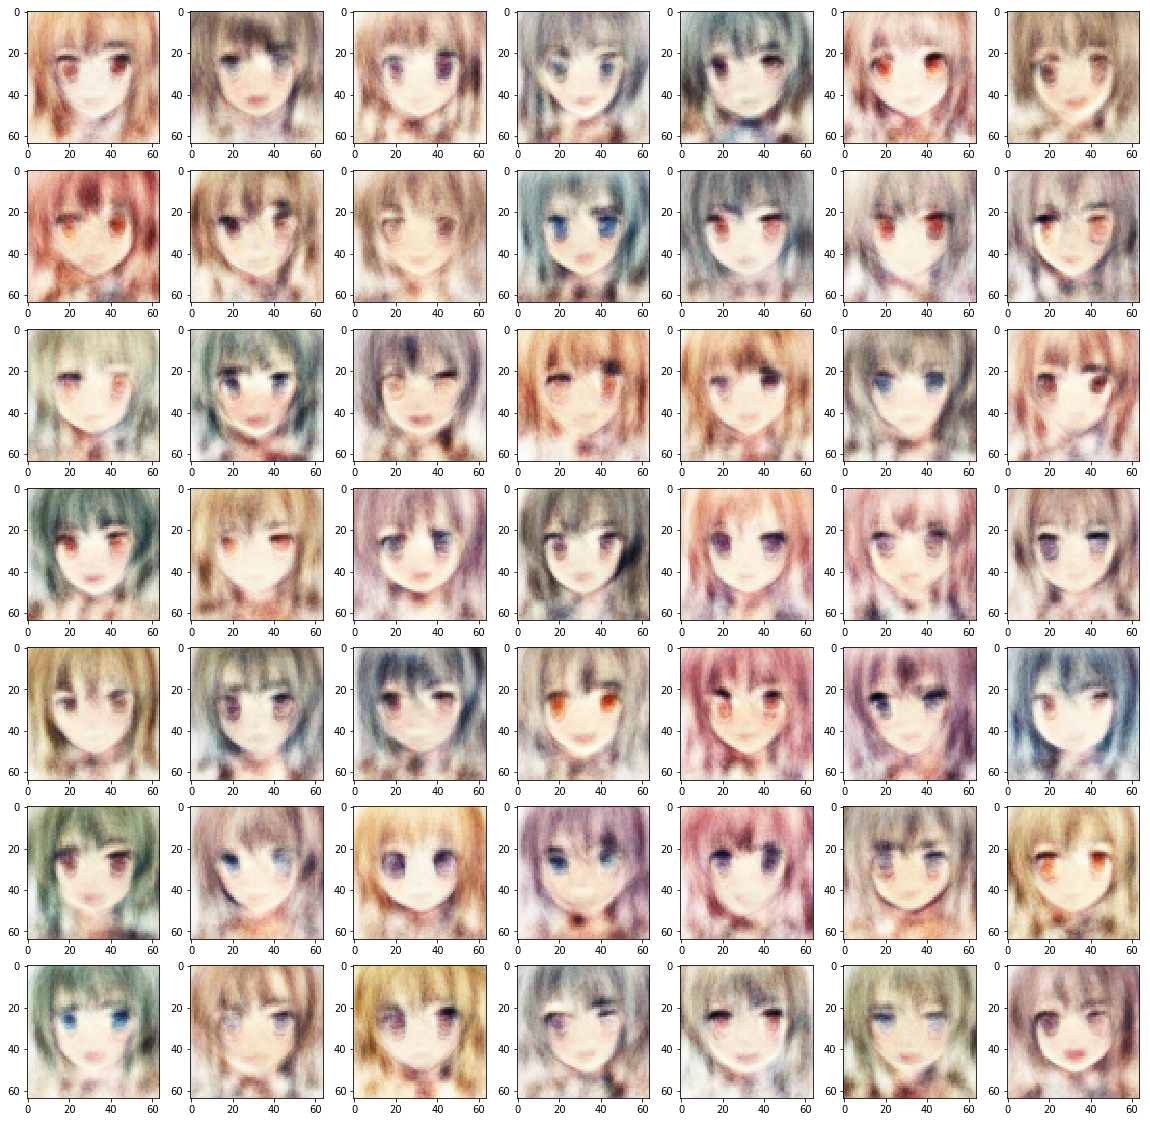

In [64]:
i_size = 7
j_size = 7

std_coef = 1.1

fig, axs = plt.subplots(i_size, j_size, figsize=(20, 20))

rnd = np.zeros((1, 100)) 
for i in range(i_size):
    for j in range(j_size):
        for k in range(latent_dim):
            # Generate a random number from uniform distribution
            rnd[0, k] = np.random.uniform(mean_std[k, 0] - mean_std[k, 1] * std_coef, 
                                          mean_std[k, 0] + mean_std[k, 1] * std_coef)

        rnd = rnd.astype('float32')
        y = autoencoder.decoder(rnd).numpy()
        axs[i, j].imshow(y.reshape(64,64,3), cmap='gray', interpolation='none')
plt.show()

#### As a conclusion I declare this project to be successful, the NN have learned how to generate faces. Here you can see that people have different eye and hair colors, some characters are smiling and some look sad, different head angles (left, right, center) and different hair length.

#### There are some black and white images. I think it looks more convincing.

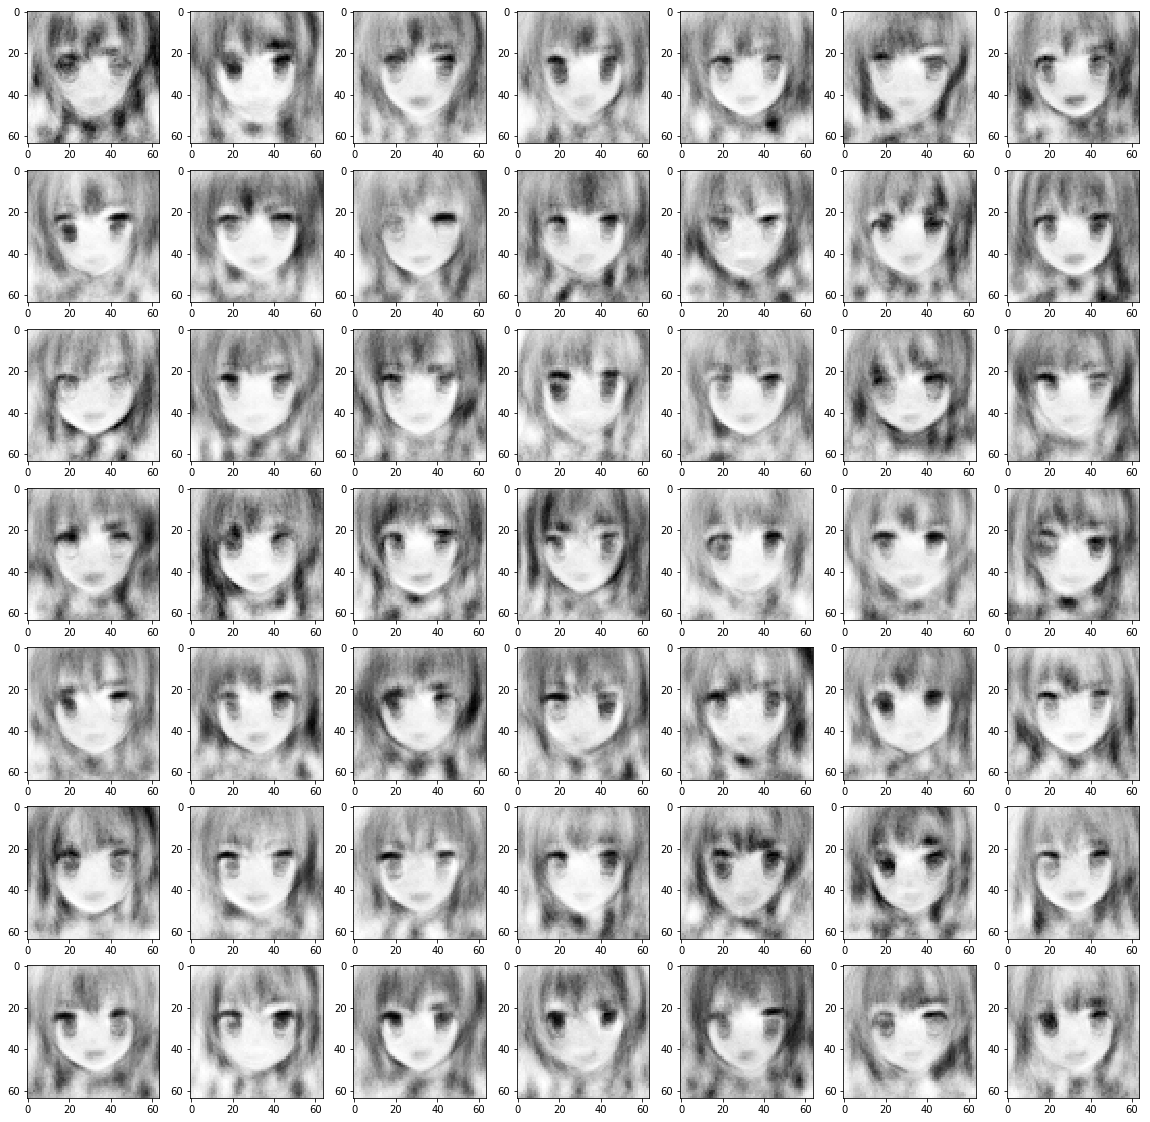

In [70]:
i_size = 7
j_size = 7

fig, axs = plt.subplots(i_size, j_size, figsize=(20, 20))

std_coef = .9

rnd = np.zeros((1, 100)) 
for i in range(i_size):
    for j in range(j_size):
        for k in range(latent_dim):
            rnd[0, k] = np.random.uniform(mean_std[k, 0] - mean_std[k, 1] * std_coef, 
                                          mean_std[k, 0] + mean_std[k, 1] * std_coef)
        rnd = rnd.astype('float32')
        y = autoencoder.decoder(rnd).numpy()
        y = y.reshape(64,64,3) * 255
        y = y.astype('uint8')
        img = PIL.Image.fromarray(y).convert('L')
        axs[i, j].imshow(img, cmap='gray', interpolation='none')
plt.show()